# Riemannian Geometry and Group Theoretic Data Representation
`Drew Wilimitis`

**Note:** In this notebook I go through some potential use cases with the  `geomstats` library available here (https://github.com/geomstats/geomstats)

![title](images/yau2.png)

In my previous overview on the more traditional methods of Manifold Learning (https://github.com/drewwilimitis/Manifold-Learning), each method was limited by its reliance on an ambient Euclidean space that was used to approximate the underlying manifold structure with the Euclidean metric. <br>

I then attempted to provide my own implementations and assessments of hyperbolic embeddings and corresponding hyperbolic classification algorithms (https://github.com/drewwilimitis/hyperbolic-learning). <br>

It's quite incredible then that the creators of `geomstats` were able to implement many different manifold structures, each characterized by different metrics that allow for a number of geometric constructions to be used for data analysis and even clustering algorithms. In the repository and paper for their project, they also demonstrate a number of real world applications that are better suited to their more advanced series of manifold implementations (their paper can be found here: https://arxiv.org/abs/1805.08308). <br>

Many of these mathematical spaces and their geometric relations are counter-intuitive and only loosely constrained, which seems to open up the possibility of widespread advancements in learning the geometry of data.

### Import libraries and load data

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import time
import sys
import os
import geomstats

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

Using numpy backend


<div class="alert alert-block alert-info">
<b>Manifolds and Metric Spaces</b> <br>
    <br>
    A Manifold is roughly just a topological space that locally resembles flat, Euclidean space. However, manifolds can be equipped with additional structures like differentiability and completeness but we are mostly considered with the metric (or distance) functions that define the geometric relationships when ascribed to a manifold. 
</div>

## Riemannian Metric

A Riemannian manifold behaves nicely in the sense that the inner product is positive-definite, making it a metric space with geodesics, angles, and even probability distributions that are generally straightforward to calculate.  <br>

$$
g_{p}: T_{p} M \times T_{p} M \rightarrow \mathbf{R}, \quad p \in M
$$ <br>
Gradients and loss functions are typically well defined via exponential maps and tangent vector fields, allowing for optimization and even tangent component analysis. Despite the predisposition to the Riemannian manifold structure, its intrinsic curvature need always be considered along with the failure of many manifold structures to share Riemannian properties.

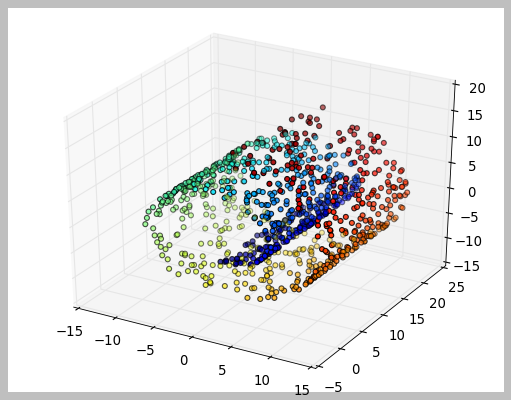

NotImplementedError: The Riemannian logarithm is not implemented.

In [2]:
# TO DO: DEMONSTRATE TANGENT VECTOR SPACE AND EXP MAP
from sklearn.datasets import make_swiss_roll
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('classic')
X, y = make_swiss_roll(1000)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
plt.show();

from geomstats.riemannian_metric import RiemannianMetric
METRIC = RiemannianMetric(dimension=3)
start = X[np.argmax(X[:, 2]), :]
end = X[np.argmin(X[:, 2]), :]
METRIC.dist(start, end);

## Special Euclidean Group - $\mathrm{SE}(\mathrm{n})$

The special Euclidean group is the Lie group of matrices that define rigid transformations in $N$ dimensions  <br>

This space of matrices rotates and then translates the given basis vectors under a transformation. <br>


$$
\left\{\left(\begin{array}{ll}
{R} & {v} \\
{0} & {1}
\end{array}\right) | R \in S O(n) \text { and } v \in \mathbb{R}^{n}\right\}
$$

$R$ is an orthogonal, rotation matrix in $S O(n) $, while $v \in \mathbb{R}^{n} $ is a translation vector, and so $SE (n)$ is the Lie Group describing rigid bodies

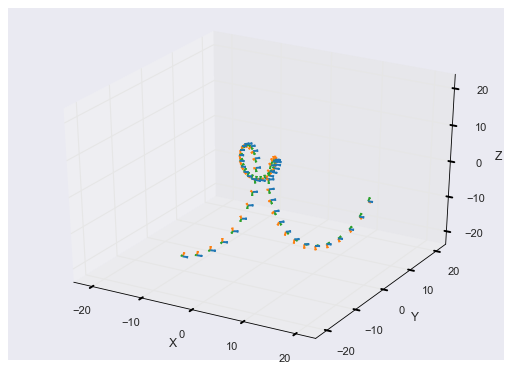

In [71]:
os.environ['GEOMSTATS_BACKEND'] = 'numpy'
import geomstats.visualization as visualization
from geomstats.special_euclidean_group import SpecialEuclideanGroup
SE3_GROUP = SpecialEuclideanGroup(n=3)
metric = SE3_GROUP.left_canonical_metric

initial_point = SE3_GROUP.identity
initial_tangent_vec = [1.8, 0.2, 0.3, 3., 7, 1.]
geodesic = METRIC.geodesic(initial_point=initial_point, initial_tangent_vec=initial_tangent_vec)

n_steps = 50
t = np.linspace(-3, 3, n_steps)

points = geodesic(t)

visualization.plot(points, space='SE3_GROUP')
plt.show();

**NOTE**: Lie Group inherits SE3 and was used for loss function/updates during applications

In [64]:
import geomstats.backend as gs
from geomstats.euclidean_space import EuclideanSpace
from geomstats.invariant_metric import InvariantMetric
from geomstats.lie_group import LieGroup
from geomstats.special_orthogonal_group import SpecialOrthogonalGroup

SE3_GROUP = SpecialEuclideanGroup(3, epsilon=FLAGS.epsilon)
metric = SE3_GROUP.left_canonical_metric
# tanh(pred_angle) required to prevent infinite spins on rotation axis
y_pred = tf.concat((tf.nn.tanh(py_x[:, :3]), py_x[:, 3:]), axis=1)
loss = tf.reduce_mean(LieGroup.loss(y_pred, y_true, SE3_GROUP, metric))

If $SE(3)$ is a space of rotations and translations, perhaps it might be an appropriate setting to use certain embedding problems with substantial invariants in given datasets. This approach was recently published that showed successful embeddings on the hypersphere **[2]**. <br>

I start by investigating how the Orthogonal group $SO(3)$ might handle a simpler case restricted to rotated image data.
___

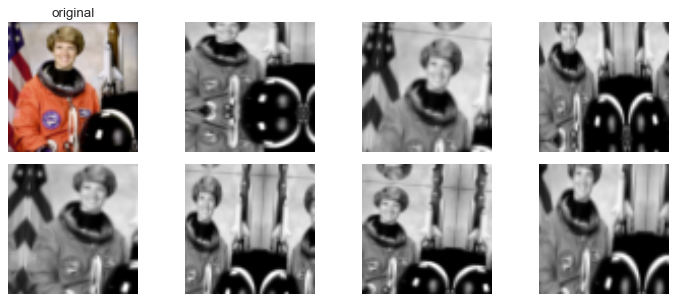

In [127]:
from skimage.feature import hog
from skimage import data, exposure
from skimage.transform import warp, AffineTransform, ProjectiveTransform
from skimage.exposure import equalize_adapthist, equalize_hist, rescale_intensity, adjust_gamma, adjust_log, adjust_sigmoid
from skimage.filters import gaussian
from skimage.color import rgb2gray, rgb2grey
from skimage.util import random_noise
from skimage.transform import rescale, resize, downscale_local_mean
import random
plt.style.use('seaborn')

# Affine transformation (rotation, scaling, translation)
def randRange(a, b):
    '''
    a utility function to generate random float values in desired range
    '''
    return np.random.rand() * (b - a) + a


def randomAffine(im):
    '''
    wrapper of Affine transformation with random scale, rotation, shear and translation parameters
    '''
    tform = AffineTransform(scale=(randRange(0.75, 1.3), randRange(0.75, 1.3)),
                            rotation=randRange(-0.05, 0.15),
                            translation=(randRange(-im.shape[0]//5, im.shape[0]//5), 
                                         randRange(-im.shape[1]//5, im.shape[1]//5)))
    return warp(im, tform.inverse, mode='reflect')


F = plt.figure(figsize=(9,4))
G = plt.GridSpec(2, 4, left=.01, right=.99, bottom=0.05, top=0.9, wspace=.01, hspace=0.1, figure=F)
ax = plt.subplot(G[0])
im = data.astronaut()
im = rescale(im, 0.125, anti_aliasing=True)

train_images = []
new_im = im
for i in range(200):
    new_im = randomAffine(rgb2gray(new_im))
    train_images.append(new_im)

ax.imshow(im)
ax.set_axis_off()
ax.set_aspect('equal')
ax.set_title('original')
for i in range(7):
    ax = plt.subplot(G[i+1])
    ax.imshow(randomAffine(rgb2gray(im)), cmap=plt.cm.gray)
    ax.set_axis_off()
    ax.set_aspect('equal');
plt.show();

In [128]:
SE3_GROUP = SpecialEuclideanGroup(3)
metric = SE3_GROUP.left_canonical_metric
LIE_GROUP = LieGroup(dimension=3)
#LIE_GROUP.add_metric()

#SE3_GROUP.get_identity()
initial_point = train_images[0]
initial_tangent_vec = [1.8, 0.2, 0.3, 3., 7, 1.0]
SE3_GROUP.regularize_tangent_vec_at_identity(tangent_vec = train_images[1])
geodesic = METRIC.geodesic(initial_point=initial_point, end_point=SE3_GROUP.regularize(train_images[10])) #initial_tangent_vec=train_images[10])
n_steps = 1
t = np.linspace(0, 1, n_steps)
points = geodesic(t)

array([[6.86397032e-01, 6.25084989e-01, 3.83501609e-01, ...,
        7.35777981e-01, 7.54560366e-01, 7.37203740e-01],
       [7.16947774e-01, 6.64984296e-01, 5.25780642e-01, ...,
        7.44062676e-01, 7.52756183e-01, 7.44661703e-01],
       [7.21341524e-01, 6.68548165e-01, 6.02754474e-01, ...,
        7.37157921e-01, 7.40728897e-01, 7.36155750e-01],
       ...,
       [6.99135164e-01, 5.93300341e-01, 4.76249209e-01, ...,
        0.00000000e+00, 0.00000000e+00, 5.93011954e-04],
       [6.35545856e-01, 4.24261553e-01, 3.01290436e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.84350567e-01, 2.49946641e-01, 2.23816869e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (64,61)->(64,newaxis,61) (64,3,3)->(64,3,3) 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

path_img = '...'
path_nmap = '...'
path_dmap = '...'
path_mesh = '...'
path_simplices = '.../simplices.tri'

# Load an image.
img = plt.imread(path_img)

# Load a normal map and a depth map.
nmap = np.load(path_nmap)['normals']
dmap = np.load(path_dmap)['depth']

# Load a mesh.
mesh = np.load(path_mesh)['mesh']
simplices = np.loadtxt(path_simplices)

# Reshape the mesh to its template shape.
mesh = mesh.reshape((31, 31, 3))

The 3D pose estimation can be evaluated computing the L2 norm of the rotation and translation components of the absolute pose error [2] for all the frame of each video sequence, and evaluating their Cumulative Distribution Function (CDF) .

Quantitative results are provided in [1] in the form of the normalized Area Under Curve (AUC) score for each error. The AUC score is computed dividing the area of the CDF curve by the max error of the graph. The max error was set to 0.5 for both rotation and translation for all frames. See [1] for further details.

## Special Orthogonal Group - $\mathrm{SO}(\mathrm{n})$

The special orthogonal group is the set of $N x N$ orthogonal matrices, denoted $\mathrm{SO}(\mathrm{n})$, which is also the Lie group of rigid body rotations 

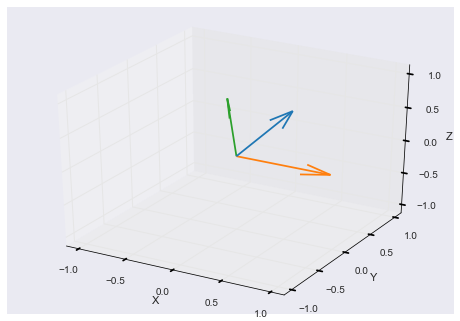

In [151]:
from geomstats.special_orthogonal_group import SpecialOrthogonalGroup
from geomstats.visualization import plot
SO3_GROUP = SpecialOrthogonalGroup(n=3)
SO3_GROUP.random_uniform(n_samples=2)
plot(points = SO3_GROUP.random_uniform(), space='SO3_GROUP');

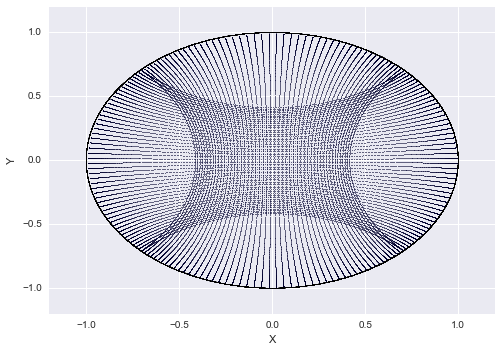

In [150]:
import geomstats.visualization as visualization
from geomstats.hyperbolic_space import HyperbolicSpace
from geomstats.hypersphere import Hypersphere
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn')
H2 = HyperbolicSpace(dimension=2)
METRIC = H2.metric


def main(left=-128,
         right=128,
         bottom=-128,
         top=128,
         grid_size=50,
         n_steps=512):
    starts = []
    ends = []
    for p in np.linspace(left, right, grid_size):
        starts.append(np.array([top, p]))
        ends.append(np.array([bottom, p]))
    for p in np.linspace(top, bottom, grid_size):
        starts.append(np.array([p, left]))
        ends.append(np.array([p, right]))
    starts = [H2.intrinsic_to_extrinsic_coords(s) for s in starts]
    ends = [H2.intrinsic_to_extrinsic_coords(e) for e in ends]
    ax = plt.gca()
    for start, end in zip(starts, ends):
        geodesic = METRIC.geodesic(initial_point=start,
                                   end_point=end)

        t = np.linspace(0, 1, n_steps)
        points_to_plot = geodesic(t)
        visualization.plot(
            points_to_plot, ax=ax, space='H2_poincare_disk', marker='.', s=1, cmap=plt.cm.jet)
    plt.show()
main();

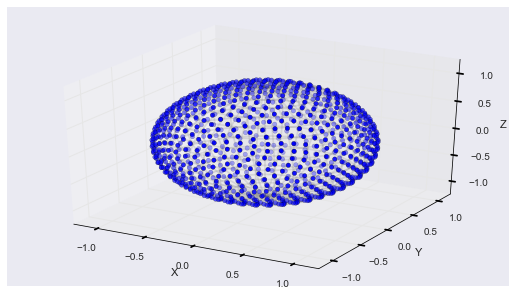

In [165]:
from geomstats.hypersphere import Hypersphere
os.environ['GEOMSTATS_BACKEND'] = 'numpy'
SPHERE2 = Hypersphere(dimension=2)
METRIC = SPHERE2.metric

plt.figure(figsize=(9,5))
def main():
    initial_point = [1., 0., 0.]
    initial_tangent_vec = SPHERE2.projection_to_tangent_space(
                                        vector=[.1, 2., 0.8],
                                        base_point=initial_point)
    geodesic = METRIC.geodesic(initial_point=initial_point,
                               initial_tangent_vec=initial_tangent_vec)

    n_steps = 20
    t = np.linspace(0, 1, n_steps)

    points = geodesic(t)
    visualization.plot(points, space='S2');
plt.subplot(121)
main();
from geomstats.visualization import Sphere, plot
sphere = Sphere(n_circles_latitude=100, n_meridians=10).fibonnaci_points(n_points=1000)
plt.subplot(122);
plot(points = sphere.T, space='S2');